# ROB 498: Robot Learning for Planning and Control
# Assignment 3: Learning Dynamics Directly from State Measurements

## Colab Setup

In [1]:
# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a ROB498 folder and put all the files under HW3 folder, then 'ROB498/HW3'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498/HW3'

### Setup Code 

In [4]:
# %load_ext autoreload
# %autoreload 2

In [3]:
# from google.colab import drive

# drive.mount('/content/drive')

The below cell will check you have the required files in your directory. The file `mppi.py` will be released on 02/19/2023, so you should expect to see 'Required file `mppi.py` not found!' before then. This is because there may still be students working on Homework 2 until then. This file is not needed until Section 4 of the homework. 

In [5]:
# import os
# import sys

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# files = os.listdir(GOOGLE_DRIVE_PATH)
# expected_files = [ 'ROB498_hw3.ipynb', 'learning_state_dynamics.py', 'panda_pushing_env.py', 'visualizers.py',  'mppi.py', 'validation_data.npy']

# sys.path.append(GOOGLE_DRIVE_PATH)

# # Verify that there are all the expected files in the directory
# all_found = True
# for expected_file in expected_files:
#   if expected_file not in files:
#     print(f'Required file {expected_file} not found!')
#     all_found = False
# if all_found:
#   print('All required files are found :)')

NameError: name 'GOOGLE_DRIVE_PATH_AFTER_MYDRIVE' is not defined

In [6]:
# # Install missing required packages 
# # Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# # Install pybullet -- For simulation purposes
# !pip install pybullet
# # Install numpngw -- For visualization purposes
# !pip install numpngw

In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

## Assignment Introduction

Due 3/8 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# Planar Pushing Learning (100 points)
For this assignment we will train a robot to push an object to a goal pose.
To this end, you will have to collect dynamics data, process the data, train a model of the dynamics, and use it for planning a sequence of pushes to reach the target location.



## Simulation Environment Introduction

For our planar pushing setup, we will use PyBullet to simulate a panda robot that pushes a block on top of a table.
The pushing block is visualized in white. In green, we visualize the goal pose of the block.



In [2]:
from panda_pushing_env import PandaPushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

pybullet build time: Nov  5 2024 13:54:07


Run the following code block to visualize the robot pushing the block.

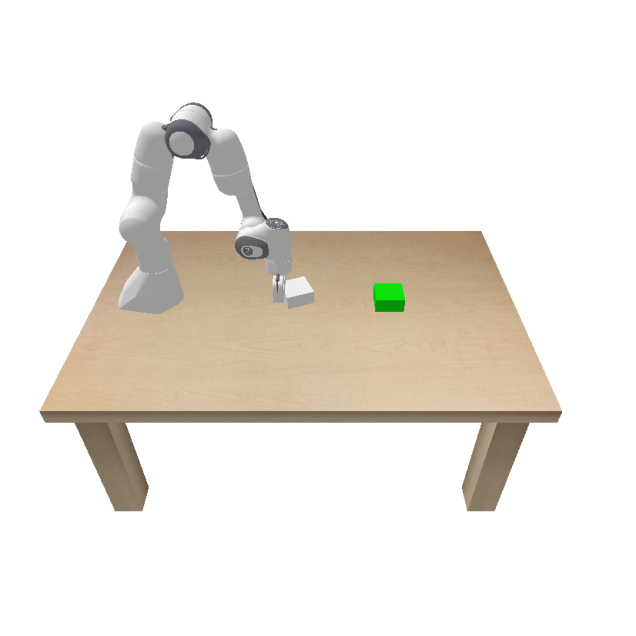

argv[0]=--opengl2


/Users/yuzhou/anaconda3/envs/tensor/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=True,  camera_heigh=800, camera_width=800)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

plt.close(fig)

For speeding up the visualization, we will only visualize the pushing part of the robot motion. However, be aware of the full robot motion.

There is another option for visualization, which is to create a `.gif` file. The following cell shows an example of this. Note that here we set the rendering mode to just render the push motion for efficiency.

argv[0]=--opengl2


  0%|          | 0/10 [00:00<?, ?it/s]

Creating animated gif, please wait about 10 seconds


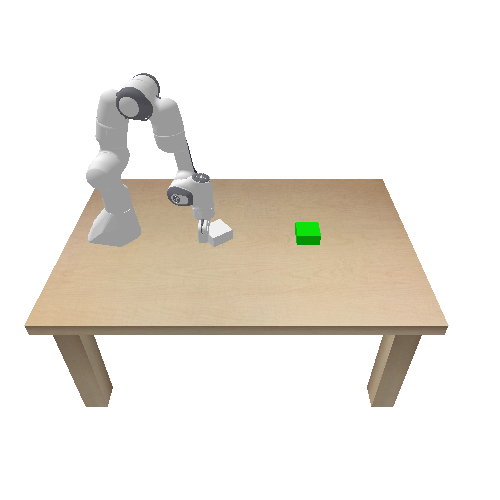

In [4]:
# Create the GIF visualizer
visualizer = GIFVisualizer()

# Initialize the simulation environment. This will only render push motions, omitting the robot reseting motions.
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False, camera_heigh=500, camera_width=500, render_every_n_steps=5)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(10)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

# Create and visualize the gif file.
Image(filename=visualizer.get_gif())



Rendering is useful for visualizing the implementation's performance and debugging. However, it consumes resources and takes time to produce. The following cell will perform 100 pushes without rendering. Compare the time with the previous rendering approaches. This should be an order of magnitude faster.

In [5]:
# Simulate pushing without rendering - this should take about 30s.
visualizer = None # No redering

env = PandaPushingEnv(visualizer=visualizer)
env.reset()

pbar =  tqdm(range(100)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        env.reset()


argv[0]=--opengl2


  0%|          | 0/100 [00:00<?, ?it/s]

### State Space and Action Space

For the planar pushing task, we have the following action and state spaces:

The image below illustrates the state space, which is the block planar location on top of the table. 
$$
\mathbf x = \begin{bmatrix} x & y & \theta\end{bmatrix}^\top\in \text{SE}(2)
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the block are negligible. In other words, if the robot stops pushing, the block also stops.


![State Space](https://drive.google.com/uc?export=view&id=1iuHwUC_IVsrBbgbyiR8qXDV4OBmgKObU)

Note that the robot is centered at the origin. 


The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m



### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $s_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space (block pose in $SE(2)$)
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).



## 1 - Collect Data  (15 points)

Given the environment, the first step is to collect data. The collected data will then be used to train a model of the pushing dynamics.

**TODO:**

* Implement `collect_data_random` in `learning_state_dynamics.py` which collects data trajectories. The actions should be uniformly random sampled within the action space limits.


**OBSERVATION**: Data collection may take some time. Please be patient and do not close the session while you are collecting data or the data collection process may be interrupted. Once the data is collected it will be saved, so if you restart the kernel you will not need to recollect the data.


**GRADING**: For grading you will also have to submit the saved collected data file `collected_data.npy`. We will check that the collected data is in the required format. However, we will NOT check the quality of the data. Note that for training a good model, data quality is key. Your collected data should be diverse to train an effective model of pushing dynamics.


In [21]:
# Collect data (it may take some time)
from learning_state_dynamics import collect_data_random

# Data collection parameters
N = 100 # Number of trajectories
T = 10 # Trajectory length

# Initialize the environment and collect data
env = PandaPushingEnv()
env.reset()
collected_data = collect_data_random(env, num_trajectories=N, trajectory_length=T)


# Verify the number of data collected:
print(f'We have collected {len(collected_data)} trajectories')
print('A data sample contains: ')
for k, v in collected_data[0].items():
    assert(type(v) == np.ndarray)
    assert(v.dtype == np.float32)
    print(f'\t {k}: numpy array of shape {v.shape}')

# Save the collected data into a file
# np.save(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), collected_data)
np.save("collected_data.npy", collected_data)



argv[0]=--opengl2
We have collected 100 trajectories
A data sample contains: 
	 states: numpy array of shape (11, 3)
	 actions: numpy array of shape (10, 3)


In [3]:
# Load the collected data: 
collected_data = np.load("collected_data.npy", allow_pickle=True)

In [35]:
# print(collected_data[1]['states'][1], '\n')
# print(collected_data[1]['actions'])

## 2 - Data Processing (20 points)
Next, given the collected data you will have to process it so we can use it for training the model.


### 2.1 - Single Step Data (10 points)

Here we will process the data in a single-step format. 


**TODO:**

* Implement `process_data_single_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and returns a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `SingleStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns the data $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ as a dictionary
    * Your dataset should consist of all $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ in the collected data
 2. You should instantiate your `SingleStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets.  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batches of the data of the required `batch_size`.

In [4]:
# Process the data
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset

batch_size = 500
train_loader, val_loader = process_data_single_step(collected_data, batch_size=batch_size)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a SingleStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, SingleStepDynamicsDataset) else 'No')
print('')

# we should see the state, action and next state of shape (batch_size, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break

# for item in train_loader:
#     print(f'state is {item["state"]}')
#     print(f'action is shape {item["action"].shape}')
#     print(f'next_state is shape {item["next_state"].shape}')
#     break


Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 3])
next_state is shape torch.Size([500, 3])


### 2.2 - Multi-step Data  (10 points)

Here we will process the data in a multi-step format. 


**TODO:**

* Implement `process_data_multiple_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and return a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `MultiStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns $(\mathbf x_t, \mathbf u_t, ..., \mathbf u_{t+k-1}, \mathbf x_{t+1}, ... , \mathbf x_{t+k})$, where $k$ is `num_steps`. We will be using `num_steps=4`. 
    * Your dataset should consist of all subtrajectories of the above form in the dataset. For instance, the trajectory $[(\mathbf x_1,\mathbf  u_1), (\mathbf x_2, \mathbf u_2), (\mathbf x_3, \mathbf u_3), (\mathbf x_4, \mathbf u_4), (\mathbf x_5, \mathbf u_5), (\mathbf x_6, \mathbf u_6), (\mathbf x_7)]$ should result in the following items in the dataset:
        - $(\mathbf x_1, \mathbf u_1, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf x_2, \mathbf x_3, \mathbf x_4, \mathbf x_5)$
        - $(\mathbf x_2, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf x_3, \mathbf x_4, \mathbf x_5, \mathbf x_6)$
        - $(\mathbf x_3, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf u_6, \mathbf x_4, \mathbf x_5, \mathbf x_6, \mathbf x_7)$
 2. You should instantiate your `MultiStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batched of the data of the required `batch_size`.

In [5]:
# Process the data
from learning_state_dynamics import process_data_multiple_step, MultiStepDynamicsDataset


train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a MultiStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, MultiStepDynamicsDataset) else 'No')
print('')

# we should see the state is shape (batch_size, 3)
# and action, next_state are shape (batch_size, num_steps, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break




Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 4, 3])
next_state is shape torch.Size([500, 4, 3])


## 3 - Learn the Pushing Dynamics (35 points)
In this part, we will train a Neural Network (NN) to model the pushing dynamics. We will formulate two approaches, absolute dynamics and residual dynamics, and compare them. 

You should use the training data and validation data you collected above to train this model. We have also provided a set of validation data to you in the file `validation_data.npy`. Cells for section 3.3 and 3.5 will evaluate your model with this validation data. If you find you are getting low loss on your collected data, but performing poorly on the validation data we provide, then one possibility is that your `collect_data_random` function from section 1 is not collecting a useful dataset. 


In [6]:
from learning_state_dynamics import AbsoluteDynamicsModel, ResidualDynamicsModel, SE2PoseLoss, SingleStepLoss

### 3.1 - Absolute Dynamics Learning (20 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = f(\mathbf x_{t} , \mathbf u_{t}) $$

**TODO:**

1. In `learning_state_dynamics.py` implement `AbsoluteDynamicsModel`. 
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Implement `SE2PoseLoss` in `learning_state_dynamics.py` to compute the loss of a $SE(2)$ state. 
    * Its `forward` method computes the loss between two batched sets of $SE(2)$ transformations. 
    * SE(2) vectors contain two position elements and one orientation element, i.e. $\mathbf q = \begin{bmatrix}x & y & \theta\end{bmatrix}^\top \in SE(2)$
    * To combine the different dimensions of pose and orientation, here we will exploit the fact that we know the object geometry. The error in orientation can be converted to error in position using the *radius of gyration* [https://en.wikipedia.org/wiki/Radius_of_gyration]. Since the object is a rectangle of width $w$ and length $l$, the radius of gyration is:
    $$
    r_g = \sqrt{\frac{w^2 + l^2}{12}}
    $$

    Therefore, to compare two poses  $\mathbf q_1 = \begin{bmatrix}x_1 & y_1 & \theta_1\end{bmatrix}^\top, \mathbf q_2 = \begin{bmatrix}x_2 & y_2 & \theta_2\end{bmatrix}^\top, \mathbf q_1, \mathbf q_2 \in SE(2)$ , we can do so as:

    $$
    \mathcal L(\mathbf q_1, \mathbf q_2) = \text{MSE}(x_1, x_2) + \text{MSE}(y_1, y_2) + r_g \text{MSE}(\theta_1, \theta_2)
    $$
    $$
    \\
    $$

3. Implement `SingleStepLoss.forward` in `learning_state_dynamics.py`. This method will perform a prediction with the model and computes the loss using the above loss function.
3. Train the model and save it as `pushing_absolute_dynamics_model.pt`. You will also have to submit this file.

HINT:
* You can reuse code from HW1 for training and evaluation of the models - you may need to make some slight modifications
* You should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%reload_ext autoreload
from learning_state_dynamics import *
# Train the dynamics model
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3)

train_loader, val_loader = process_data_single_step(collected_data)
# for batch in train_loader:
#     print("Batch Content:", batch)  # Print entire batch (dictionary or tuple)
    
#     # If batch is a dictionary
#     if isinstance(batch, dict):
#         for key, value in batch.items():
#             print(f"{key}: Type={type(value)}, Shape={getattr(value, 'shape', 'N/A')}")

#     # If batch is a tuple (from collate_fn)
#     elif isinstance(batch, tuple):
#         print(f"State Type: {type(batch[0])}, Shape: {getattr(batch[0], 'shape', 'N/A')}")
#         print(f"Action Type: {type(batch[1])}, Shape: {getattr(batch[1], 'shape', 'N/A')}")
#         print(f"Next State Type: {type(batch[2])}, Shape: {getattr(batch[2], 'shape', 'N/A')}")
    
#     break  # Only check the first batch

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
lr = 0.195
num_epoches = 4000
train_losses, val_losses = train_model(pushing_absolute_dynamics_model, pose_loss, train_loader, val_loader, num_epochs=num_epoches, lr=lr)
# ---

# save model:
save_path = "pushing_absolute_dynamics_model.pt"
torch.save(pushing_absolute_dynamics_model.state_dict(), save_path)



Train Loss: 0.0003 | Validation Loss: 0.0004: 100%|██████████| 4000/4000 [00:53<00:00, 74.87it/s]


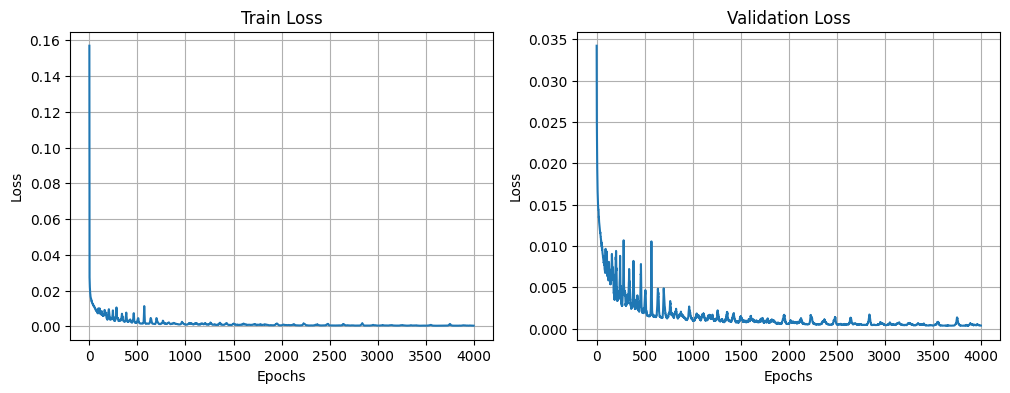

In [26]:
# Plot Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses)
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(val_losses)
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

### 3.2 - Residual Dynamics Learning (10 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = \mathbf x_{t} + \Delta \mathbf x_{t} =  \mathbf x_{t} + f(\mathbf x_{t}, \mathbf u_{t}) $$


**TODO:**

1. In `learning_state_dynamics.py` implement `ResidualDynamicsModel`.
    * Its `forward` method should compute $\hat{\mathbf x}_{t+1}$ . Here, the network will output $\Delta \mathbf x_{t}$, which will need to be added to $\mathbf x_t$ to obtain $\hat{\mathbf x}_{t+1}$
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Train the model and save it as `pushing_residual_dynamics_model.pt`. You will also have to submit this file.

HINT: 
* Similar to above, you should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$.

Train Loss: 0.0002 | Validation Loss: 0.0003: 100%|██████████| 4000/4000 [00:55<00:00, 71.86it/s]


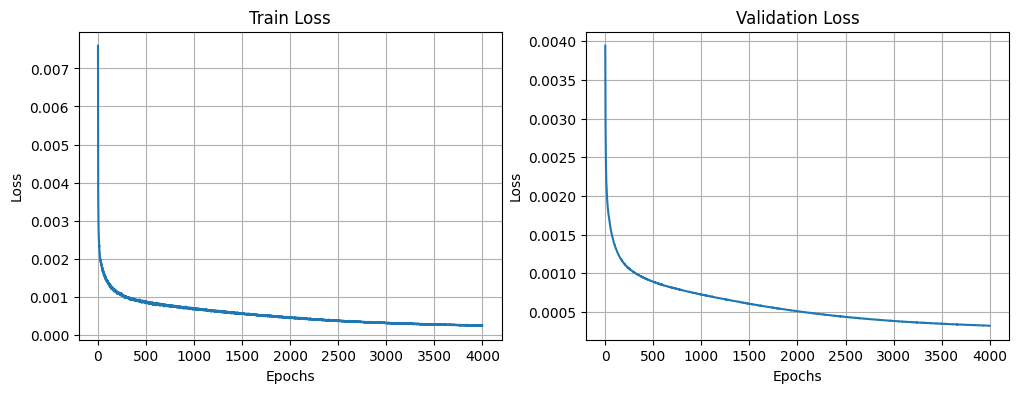

In [35]:
%reload_ext autoreload
from learning_state_dynamics import *
pushing_residual_dynamics_model = ResidualDynamicsModel(3, 3)
train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# # Check if the model has parameters
# for name, param in pushing_residual_dynamics_model.named_parameters():
#     print(name, param.shape)

# # Ensure model has parameters before training
# if len(list(pushing_residual_dynamics_model.parameters())) == 0:
#     raise ValueError("The model has no parameters!")
# --- Your code here
lr = 0.195
num_epoches = 4000
train_losses, val_losses = train_model(pushing_residual_dynamics_model, pose_loss, train_loader, val_loader, num_epochs=num_epoches, lr=lr)
# ---

# save model:
save_path = "pushing_residual_dynamics_model.pt"
torch.save(pushing_residual_dynamics_model.state_dict(), save_path)

# Plot Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses)
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(val_losses)
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

### 3.3 - Absolute Dynamics vs Residual Dynamics (No points)
In this section we will compare the performance of the absolute dynamics model and the residual dynamics model with test data that we provide you.

Which one performs better? Why is that the case?

You should see both losses be below $5 \times 10^{-4}$

In [36]:
%reload_ext autoreload
from learning_state_dynamics import *
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

loss_absolute = 0.0
loss_residual = 0.0

for item in val_loader:
    loss_absolute += pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_residual += pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation loss for absolute dynamics model is {loss_absolute}')
print(f'Validation loss for residual dynamics model is {loss_residual}')

Validation loss for absolute dynamics model is 0.00026777246966958046
Validation loss for residual dynamics model is 0.0002938812249340117


### 3.4 Multi-step Loss (10 points)

In this section you will train a residual dynamics model using a recursive multistep loss, as shown in the lectures. 

**TODO**:
Implement `MultiStepLoss` in `learning_state_dynamics.py` 
* The parameter `discount` is the same as $\lambda$ from the lectures. 
* HINT: You may need to reduce the learning rate and train for slightly longer for the multi-step loss

In [102]:
%reload_ext autoreload
from learning_state_dynamics import *
# Train the dynamics model
# from learning_state_dynamics import MultiStepLoss, process_data_multiple_step
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3, 3)
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# --- Your code here
lr = 0.0335
num_epoches = 50000
train_losses, val_losses = train_model(pushing_multistep_residual_dynamics_model, pose_loss, train_loader, val_loader, num_epochs=num_epoches, lr=lr)
# ---
# save model:
if train_losses[-1] < 0.0005:
    save_path = "pushing_multi_step_residual_dynamics_model.pt"
    torch.save(pushing_multistep_residual_dynamics_model.state_dict(), save_path)

# Plot Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses)
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(val_losses)
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

Train Loss: 0.0006 | Validation Loss: 0.0010:  97%|█████████▋| 48461/50000 [12:56<00:24, 62.44it/s]


KeyboardInterrupt: 

Train Loss: 0.0093 | Validation Loss: 0.0108: 100%|██████████| 400/400 [00:05<00:00, 67.75it/s]


0.008 0.009289248380810022 0.01083621196448803


Train Loss: 0.0075 | Validation Loss: 0.0089: 100%|██████████| 400/400 [00:06<00:00, 66.39it/s]


0.0085 0.007523082662373781 0.008868097327649593


Train Loss: 0.0065 | Validation Loss: 0.0080: 100%|██████████| 400/400 [00:05<00:00, 68.16it/s]


0.009000000000000001 0.006515891524031758 0.007952312938869


Train Loss: 0.0059 | Validation Loss: 0.0072: 100%|██████████| 400/400 [00:05<00:00, 67.49it/s]


0.009500000000000001 0.005923588294535875 0.007245113141834736


Train Loss: 0.0054 | Validation Loss: 0.0067: 100%|██████████| 400/400 [00:06<00:00, 66.08it/s]


0.010000000000000002 0.005438850261271 0.006706279702484608


Train Loss: 0.0055 | Validation Loss: 0.0062: 100%|██████████| 400/400 [00:06<00:00, 66.31it/s]


0.010500000000000002 0.0054940516129136086 0.006175006739795208


Train Loss: 0.0046 | Validation Loss: 0.0057: 100%|██████████| 400/400 [00:05<00:00, 67.87it/s]


0.011000000000000003 0.004583684960380197 0.00572114996612072


Train Loss: 0.0043 | Validation Loss: 0.0052: 100%|██████████| 400/400 [00:05<00:00, 68.73it/s]


0.011500000000000003 0.004273885861039162 0.005233699455857277


Train Loss: 0.0043 | Validation Loss: 0.0048: 100%|██████████| 400/400 [00:05<00:00, 67.52it/s]


0.012000000000000004 0.004285740898922086 0.0048147644847631454


Train Loss: 0.0037 | Validation Loss: 0.0044: 100%|██████████| 400/400 [00:05<00:00, 67.78it/s]


0.012500000000000004 0.0037083576899021864 0.004403836093842983


Train Loss: 0.0029 | Validation Loss: 0.0041: 100%|██████████| 400/400 [00:05<00:00, 69.05it/s]


0.013000000000000005 0.0029294901760295033 0.0040605212561786175


Train Loss: 0.0030 | Validation Loss: 0.0038: 100%|██████████| 400/400 [00:05<00:00, 67.89it/s]


0.013500000000000005 0.0029514653142541647 0.0038180293049663305


Train Loss: 0.0028 | Validation Loss: 0.0035: 100%|██████████| 400/400 [00:05<00:00, 67.90it/s]


0.014000000000000005 0.0027508835773915052 0.0035263407044112682


Train Loss: 0.0026 | Validation Loss: 0.0033: 100%|██████████| 400/400 [00:05<00:00, 69.34it/s]


0.014500000000000006 0.0025741368299350142 0.0032921680249273777


Train Loss: 0.0026 | Validation Loss: 0.0031: 100%|██████████| 400/400 [00:05<00:00, 67.30it/s]


0.015000000000000006 0.0026240204460918903 0.0031476295553147793


Train Loss: 0.0026 | Validation Loss: 0.0029: 100%|██████████| 400/400 [00:05<00:00, 68.39it/s]


0.015500000000000007 0.002562744775786996 0.0029436068143695593


Train Loss: 0.0022 | Validation Loss: 0.0028: 100%|██████████| 400/400 [00:05<00:00, 68.97it/s]


0.016000000000000007 0.0022081645438447595 0.0027881935238838196


Train Loss: 0.0025 | Validation Loss: 0.0027: 100%|██████████| 400/400 [00:05<00:00, 67.86it/s]


0.016500000000000008 0.002503574127331376 0.0027317909989506006


Train Loss: 0.0024 | Validation Loss: 0.0029: 100%|██████████| 400/400 [00:05<00:00, 68.23it/s]


0.017000000000000008 0.0024417766835540533 0.0029461474623531103


Train Loss: 0.0020 | Validation Loss: 0.0024: 100%|██████████| 400/400 [00:05<00:00, 69.22it/s]


0.01750000000000001 0.002014681580476463 0.0024426542222499847


Train Loss: 0.0021 | Validation Loss: 0.0024: 100%|██████████| 400/400 [00:05<00:00, 68.02it/s]


0.01800000000000001 0.002082404913380742 0.0024458500556647778


Train Loss: 0.0031 | Validation Loss: 0.0032: 100%|██████████| 400/400 [00:05<00:00, 68.57it/s]


0.01850000000000001 0.003075274406000972 0.003231898881494999


Train Loss: 0.0021 | Validation Loss: 0.0025: 100%|██████████| 400/400 [00:05<00:00, 68.12it/s]


0.01900000000000001 0.0021063664462417364 0.002478764858096838


Train Loss: 0.0023 | Validation Loss: 0.0024: 100%|██████████| 400/400 [00:05<00:00, 70.23it/s]


0.01950000000000001 0.002303685527294874 0.0023847552947700024


Train Loss: 0.0025 | Validation Loss: 0.0024: 100%|██████████| 400/400 [00:06<00:00, 66.43it/s]


0.02000000000000001 0.0024928245693445206 0.002397228730842471


Train Loss: 0.0024 | Validation Loss: 0.0026: 100%|██████████| 400/400 [00:05<00:00, 68.57it/s]


0.02050000000000001 0.0024430324556306005 0.0025580902583897114


Train Loss: 0.0021 | Validation Loss: 0.0025: 100%|██████████| 400/400 [00:05<00:00, 69.07it/s]


0.02100000000000001 0.002070912509225309 0.0024848817847669125


Train Loss: 0.0019 | Validation Loss: 0.0022: 100%|██████████| 400/400 [00:05<00:00, 69.86it/s]


0.021500000000000012 0.0019317024853080511 0.0021913484670221806


Train Loss: 0.0020 | Validation Loss: 0.0023: 100%|██████████| 400/400 [00:05<00:00, 69.28it/s]


0.022000000000000013 0.0019501640927046537 0.0023257581051439047


Train Loss: 0.0017 | Validation Loss: 0.0019: 100%|██████████| 400/400 [00:05<00:00, 68.35it/s]


0.022500000000000013 0.0017294208519160748 0.0018531871028244495


Train Loss: 0.0026 | Validation Loss: 0.0034: 100%|██████████| 400/400 [00:05<00:00, 70.16it/s]


0.023000000000000013 0.0025895913131535053 0.003376418724656105


Train Loss: 0.0028 | Validation Loss: 0.0030: 100%|██████████| 400/400 [00:05<00:00, 68.41it/s]


0.023500000000000014 0.002835595514625311 0.0030163698829710484


Train Loss: 0.0014 | Validation Loss: 0.0017: 100%|██████████| 400/400 [00:05<00:00, 69.11it/s]


0.024000000000000014 0.001446093840058893 0.0016869412502273917


Train Loss: 0.0022 | Validation Loss: 0.0024: 100%|██████████| 400/400 [00:05<00:00, 70.37it/s]


0.024500000000000015 0.002157332142814994 0.0023626373149454594


Train Loss: 0.0015 | Validation Loss: 0.0017: 100%|██████████| 400/400 [00:06<00:00, 66.07it/s]


0.025000000000000015 0.0014597728149965405 0.001658651977777481


Train Loss: 0.0012 | Validation Loss: 0.0015: 100%|██████████| 400/400 [00:05<00:00, 68.54it/s]


0.025500000000000016 0.0012318904628045857 0.0015408541075885296


Train Loss: 0.0011 | Validation Loss: 0.0014: 100%|██████████| 400/400 [00:05<00:00, 69.71it/s]


0.026000000000000016 0.0011225724592804909 0.0014254988636821508


Train Loss: 0.0015 | Validation Loss: 0.0017: 100%|██████████| 400/400 [00:05<00:00, 69.25it/s]


0.026500000000000017 0.0014755746815353632 0.0016535071190446615


Train Loss: 0.0021 | Validation Loss: 0.0022: 100%|██████████| 400/400 [00:05<00:00, 68.82it/s]


0.027000000000000017 0.0020866866689175367 0.00224264245480299


Train Loss: 0.0011 | Validation Loss: 0.0014: 100%|██████████| 400/400 [00:05<00:00, 69.90it/s]


0.027500000000000017 0.0010664828005246818 0.0014305764343589544


Train Loss: 0.0026 | Validation Loss: 0.0026: 100%|██████████| 400/400 [00:05<00:00, 69.14it/s]


0.028000000000000018 0.0026373518630862236 0.0026038167998194695


Train Loss: 0.0010 | Validation Loss: 0.0013: 100%|██████████| 400/400 [00:05<00:00, 68.68it/s]


0.02850000000000002 0.0009837697143666446 0.0012686537811532617


Train Loss: 0.0010 | Validation Loss: 0.0014: 100%|██████████| 400/400 [00:05<00:00, 68.65it/s]


0.02900000000000002 0.00101467251079157 0.001381946261972189


Train Loss: 0.0012 | Validation Loss: 0.0016: 100%|██████████| 400/400 [00:05<00:00, 68.82it/s]


0.02950000000000002 0.0012499979929998517 0.0015966075006872416


Train Loss: 0.0011 | Validation Loss: 0.0014: 100%|██████████| 400/400 [00:05<00:00, 68.78it/s]


0.03000000000000002 0.0011410092120058835 0.001419131294824183


Train Loss: 0.0014 | Validation Loss: 0.0015: 100%|██████████| 400/400 [00:05<00:00, 68.70it/s]


0.03050000000000002 0.0013952901936136186 0.001518242061138153


Train Loss: 0.0012 | Validation Loss: 0.0013: 100%|██████████| 400/400 [00:05<00:00, 68.59it/s]


0.03100000000000002 0.0011785735841840506 0.001280448050238192


Train Loss: 0.0027 | Validation Loss: 0.0029: 100%|██████████| 400/400 [00:05<00:00, 68.82it/s]


0.03150000000000002 0.002670947927981615 0.0029083923436701298


Train Loss: 0.0027 | Validation Loss: 0.0027: 100%|██████████| 400/400 [00:05<00:00, 70.10it/s]


0.03200000000000002 0.002701165503822267 0.0027259495109319687


Train Loss: 0.0013 | Validation Loss: 0.0016: 100%|██████████| 400/400 [00:05<00:00, 68.06it/s]


0.03250000000000002 0.0013238128158263862 0.0015667264815419912


Train Loss: 0.0036 | Validation Loss: 0.0036: 100%|██████████| 400/400 [00:05<00:00, 69.18it/s]


0.03300000000000002 0.003557334071956575 0.003584623336791992


Train Loss: 0.0008 | Validation Loss: 0.0011: 100%|██████████| 400/400 [00:05<00:00, 69.60it/s]


0.03350000000000002 0.000845646602101624 0.001083190320059657


Train Loss: 0.0025 | Validation Loss: 0.0030: 100%|██████████| 400/400 [00:05<00:00, 68.68it/s]


0.03400000000000002 0.002529059536755085 0.0029799167532473803


Train Loss: 0.0027 | Validation Loss: 0.0028: 100%|██████████| 400/400 [00:05<00:00, 68.51it/s]


0.034500000000000024 0.0026874429313465953 0.002784349489957094


Train Loss: 0.0025 | Validation Loss: 0.0023: 100%|██████████| 400/400 [00:05<00:00, 69.42it/s]


0.035000000000000024 0.002453341265209019 0.0023365579545497894


Train Loss: 0.0029 | Validation Loss: 0.0032: 100%|██████████| 400/400 [00:06<00:00, 65.80it/s]


0.035500000000000025 0.0029040329391136765 0.0032180952839553356


Train Loss: 0.0017 | Validation Loss: 0.0019: 100%|██████████| 400/400 [00:05<00:00, 69.05it/s]


0.036000000000000025 0.0017052777693606913 0.0018602961208671331


Train Loss: 0.0010 | Validation Loss: 0.0011: 100%|██████████| 400/400 [00:05<00:00, 69.64it/s]


0.036500000000000025 0.0010210227337665856 0.001095067011192441


Train Loss: 0.0035 | Validation Loss: 0.0037: 100%|██████████| 400/400 [00:06<00:00, 66.24it/s]


0.037000000000000026 0.0034569341223686934 0.003672446822747588


Train Loss: 0.0049 | Validation Loss: 0.0050: 100%|██████████| 400/400 [00:06<00:00, 61.08it/s]


0.037500000000000026 0.004857087507843971 0.004995083436369896


Train Loss: 0.0010 | Validation Loss: 0.0013: 100%|██████████| 400/400 [00:05<00:00, 69.82it/s]


0.03800000000000003 0.00098541280021891 0.0012514987029135227


Train Loss: 0.0028 | Validation Loss: 0.0036: 100%|██████████| 400/400 [00:05<00:00, 69.50it/s]


0.03850000000000003 0.0028291044291108847 0.0035516726784408092


Train Loss: 0.0012 | Validation Loss: 0.0011: 100%|██████████| 400/400 [00:05<00:00, 68.43it/s]


0.03900000000000003 0.0011769616976380348 0.0011073957430198789


Train Loss: 0.0109 | Validation Loss: 0.0113: 100%|██████████| 400/400 [00:05<00:00, 70.55it/s]


0.03950000000000003 0.010905541945248842 0.011321068741381168


Train Loss: 0.0078 | Validation Loss: 0.0081: 100%|██████████| 400/400 [00:05<00:00, 69.51it/s]


0.04000000000000003 0.007821463514119387 0.00811389833688736


Train Loss: 0.0012 | Validation Loss: 0.0014: 100%|██████████| 400/400 [00:06<00:00, 65.73it/s]


0.04050000000000003 0.001154817291535437 0.0013754592509940267


Train Loss: 0.0030 | Validation Loss: 0.0031: 100%|██████████| 400/400 [00:05<00:00, 70.46it/s]


0.04100000000000003 0.0029807144310325384 0.0030503985472023487


Train Loss: 0.0056 | Validation Loss: 0.0064: 100%|██████████| 400/400 [00:05<00:00, 69.81it/s]


0.04150000000000003 0.00556555762887001 0.006429713219404221


Train Loss: 0.0026 | Validation Loss: 0.0027: 100%|██████████| 400/400 [00:05<00:00, 69.50it/s]


0.04200000000000003 0.002551119541749358 0.0026597112882882357


Train Loss: 0.0040 | Validation Loss: 0.0036: 100%|██████████| 400/400 [00:05<00:00, 70.24it/s]


0.04250000000000003 0.003979434492066503 0.0036286795511841774


Train Loss: 0.0043 | Validation Loss: 0.0050: 100%|██████████| 400/400 [00:05<00:00, 68.43it/s]


0.04300000000000003 0.004298012005165219 0.004956163465976715


Train Loss: 0.0066 | Validation Loss: 0.0070: 100%|██████████| 400/400 [00:05<00:00, 68.45it/s]


0.04350000000000003 0.00655318284407258 0.006971554830670357


Train Loss: 0.0065 | Validation Loss: 0.0066: 100%|██████████| 400/400 [00:05<00:00, 70.58it/s]


0.04400000000000003 0.0065252946224063635 0.006647003814578056


Train Loss: 0.0015 | Validation Loss: 0.0018: 100%|██████████| 400/400 [00:05<00:00, 68.56it/s]


0.04450000000000003 0.001478571619372815 0.0017913298215717077


Train Loss: 0.0084 | Validation Loss: 0.0078: 100%|██████████| 400/400 [00:05<00:00, 69.52it/s]


0.04500000000000003 0.008408190682530403 0.00784149207174778


Train Loss: 0.0027 | Validation Loss: 0.0026: 100%|██████████| 400/400 [00:06<00:00, 66.59it/s]


0.045500000000000033 0.002734715468250215 0.0025988868437707424


Train Loss: 0.0087 | Validation Loss: 0.0107: 100%|██████████| 400/400 [00:05<00:00, 68.68it/s]


0.046000000000000034 0.008697222918272018 0.010673349723219872


Train Loss: 0.0135 | Validation Loss: 0.0118: 100%|██████████| 400/400 [00:05<00:00, 70.29it/s]


0.046500000000000034 0.013516408391296864 0.011828072369098663


Train Loss: 0.0093 | Validation Loss: 0.0084: 100%|██████████| 400/400 [00:05<00:00, 69.63it/s]


0.047000000000000035 0.009277765173465014 0.008434636518359184


Train Loss: 0.0016 | Validation Loss: 0.0017: 100%|██████████| 400/400 [00:05<00:00, 69.54it/s]


0.047500000000000035 0.0015856226673349738 0.001698461826890707


Train Loss: 0.0072 | Validation Loss: 0.0070: 100%|██████████| 400/400 [00:05<00:00, 70.02it/s]


0.048000000000000036 0.007226597284898162 0.00701889768242836


Train Loss: 0.0076 | Validation Loss: 0.0063: 100%|██████████| 400/400 [00:05<00:00, 69.83it/s]


0.048500000000000036 0.00761344819329679 0.0063323331996798515


Train Loss: 0.0061 | Validation Loss: 0.0053: 100%|██████████| 400/400 [00:06<00:00, 66.35it/s]


0.04900000000000004 0.006058176513761282 0.005345430225133896


Train Loss: 0.0084 | Validation Loss: 0.0085: 100%|██████████| 400/400 [00:05<00:00, 68.86it/s]


0.04950000000000004 0.008388520684093237 0.008542961440980434
0.03350000000000002 0.000845646602101624


Train Loss: 0.0004 | Validation Loss: 0.0005: 100%|██████████| 10000/10000 [02:29<00:00, 66.88it/s]


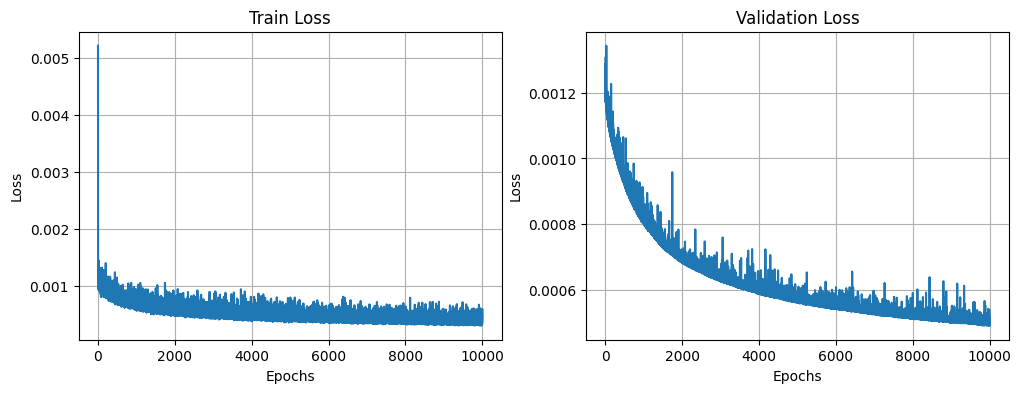

In [87]:
%reload_ext autoreload
from learning_state_dynamics import *
# Train the dynamics model
# from learning_state_dynamics import MultiStepLoss, process_data_multiple_step
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3, 3)
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# --- Your code here
num_epochs = 400
lrr = np.arange(0.008, 0.05, 0.0005)  # Step size is 0.01
losss = []
best_loss = 0.070
best_lr = 0.008
for lr in lrr:
# Train the model
   train_losses, val_losses = train_model(pushing_multistep_residual_dynamics_model, pose_loss, train_loader, val_loader, num_epochs=400, lr=lr)
   print(lr,train_losses[-1],val_losses[-1])
   losss.append(train_losses[-1])
   # store best lr and loss
   if train_losses[-1] < best_loss:
      best_loss = train_losses[-1]
      best_lr = lr
print(best_lr, best_loss)

train_losses, val_losses = train_model(pushing_multistep_residual_dynamics_model, pose_loss, train_loader, val_loader, num_epochs=10000, lr=float(best_lr))
# ---
# save model:
save_path = "pushing_multi_step_residual_dynamics_model.pt"
torch.save(pushing_multistep_residual_dynamics_model.state_dict(), save_path)

# Plot Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses)
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(val_losses)
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

[I 2025-02-07 00:39:54,673] A new study created in memory with name: no-name-86d009a5-4781-4df8-ba80-c25caeb4188a
/var/folders/3m/fp8bm06s7g70bqzt6nvh_64w0000gn/T/ipykernel_40363/2749617427.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 4e-2)
Train Loss: 0.0073 | Validation Loss: 0.0076: 100%|██████████| 1000/1000 [00:36<00:00, 27.11it/s]
[I 2025-02-07 00:40:31,566] Trial 0 finished with value: 0.007586949039250612 and parameters: {'lr': 0.0008452392773526168, 'num_epochs': 1000}. Best is trial 0 with value: 0.007586949039250612.
Train Loss: 0.0030 | Validation Loss: 0.0033: 100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s]
[I 2025-02-07 00:41:07,775] Trial 1 finished with value: 0.0033441941253840924 and parameters: {'lr': 0.00688520650339032, 'num_epochs': 1000}. Best is trial

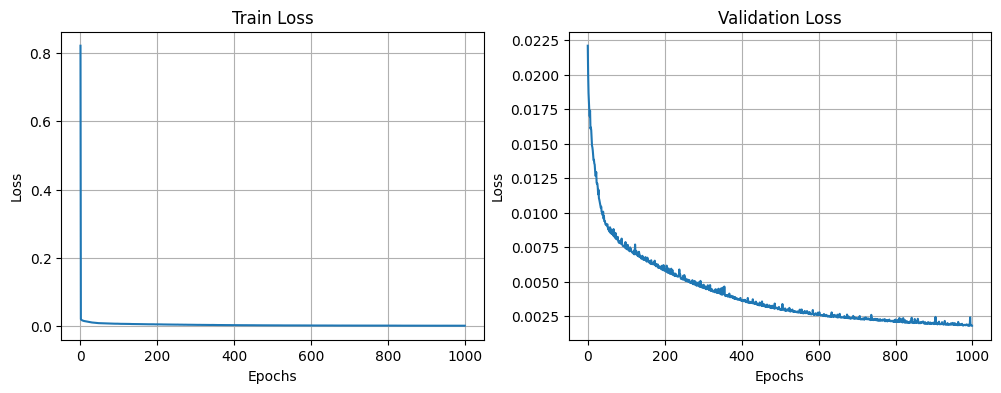

{'lr': 0.018050423310450217, 'num_epochs': 1000}

In [99]:
import torch
import optuna
import matplotlib.pyplot as plt
from learning_state_dynamics import (
    ResidualDynamicsModel, MultiStepLoss, process_data_multiple_step,
    SE2PoseLoss, train_model
)

# Reduce batch size further to free up memory
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=32)

# Define loss function
pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 4e-2)
    num_epochs = trial.suggest_int("num_epochs", 500, 1000, step=500)  # Reduced range

    # Initialize model
    model = ResidualDynamicsModel(3, 3)

    # Train model
    train_losses, val_losses = train_model(model, pose_loss, train_loader, val_loader, num_epochs=num_epochs, lr=lr)

    # Get the final validation loss
    final_loss = val_losses[-1]

    # Save model if loss is below threshold
    if final_loss < 4e-4:
        save_path = f"best_model_lr_{lr:.1e}_epochs_{num_epochs}.pt"
        torch.save(model.state_dict(), save_path)
        trial.set_user_attr("valid_model", True)

    # Free memory after training
    del model
    torch.cuda.empty_cache()  # Free GPU memory

    return final_loss

# Create an Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Reduce trials to avoid memory issues

# Get the best parameters
best_params = study.best_params
best_lr = best_params["lr"]
best_num_epochs = best_params["num_epochs"]

# Train the best model
best_model = ResidualDynamicsModel(3, 3)
train_losses, val_losses = train_model(best_model, pose_loss, train_loader, val_loader, num_epochs=best_num_epochs, lr=best_lr)

# Save the best model
final_save_path = "best_pushing_multi_step_residual_dynamics_model.pt"
torch.save(best_model.state_dict(), final_save_path)

# Plot Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses)
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(val_losses)
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

plt.show()

# Return best hyperparameters
best_params

### 3.5 - Multistep vs Single Step Loss (No points)
In this section we will compare the performance of the multi-step and single-step loss for the residual dynamics model with test data that we provide you.

You should see that the multi-step trained model performs similarly to the single-step trained model when evaluated on the single-step loss. As above, this loss should be below $5 \times 10^{-4}$. 

You might notice that the multi-step loss in this example does not actually lead to better performance for multi-step prediction. This is nothing to be concerned about. Whether or not a multi-step loss is required for good multi-step performance depends on the specific problem. 


In [103]:
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

num_steps = 4
val_multistep_dataset = MultiStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True), num_steps=num_steps)
val_multistep_loader = torch.utils.data.DataLoader(val_multistep_dataset, batch_size=len(val_multistep_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
multistep_pose_loss = MultiStepLoss(pose_loss, discount=1)
pose_loss = SingleStepLoss(pose_loss)


single_step_loss_single_step_model = 0.0
single_step_loss_multi_step_model = 0.0

for item in val_loader:
    single_step_loss_single_step_model += \
        pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    single_step_loss_multi_step_model += \
        pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation single-step loss for model trained on single-step loss {single_step_loss_single_step_model}')
print(f'Validation single-step loss for model trained on multi-step loss {single_step_loss_multi_step_model}')

multi_step_loss_single_step_model = 0.0
multi_step_loss_multi_step_model = 0.0

for item in val_multistep_loader:
    multi_step_loss_single_step_model += \
        multistep_pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    multi_step_loss_multi_step_model += \
        multistep_pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])
print('')
print(f'Validation multi-step loss for model trained on single-step loss {multi_step_loss_single_step_model / num_steps}')
print(f'Validation multi-step loss for model trained on multi-step loss {multi_step_loss_multi_step_model / num_steps}')

Validation single-step loss for model trained on single-step loss 0.0002938812249340117
Validation single-step loss for model trained on multi-step loss 0.00012022408191114664

Validation multi-step loss for model trained on single-step loss 0.0008360661449842155
Validation multi-step loss for model trained on multi-step loss 0.00033944868482649326


## 4 - Use the Learned Dynamics Model for Planning and Controls (30 points)

**Please note - the file `mppi.py` will be released on the course website on 02/19/2023. You will not be able to complete this section until then.**


Finally, once we have a good model of the pushing dynamics, we can use it to plan a sequence of actions to reach the goal configuration.

To do so, we will be using MPPI as our controller. It will rollout the trajectories using the learned dynamics model from the previous section. Since in HW2 you already implemented MPPI, here we are giving you the implmentation. You will just have to implement the cost function and some other minor parts. We are also giving you some good initialization for the hyperparametes. However, you may need to tune them for your model and cost function implementations.

You should use the `pushing_multistep_residual_dynamics_model` you trained previously as the dynamics model to complete this question.  


In [108]:
from learning_state_dynamics import PushingController, free_pushing_cost_function, collision_detection, obstacle_avoidance_pushing_cost_function
from panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, BOX_SIZE

### 4.1 - Obstacle-Free Pushing (15 points)
In this first part, we will consider the task of pushing an object to a goal pose with no obstacles on the table. We will use the following quadratic cost:

$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} (\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal})$$

with 
$$ Q = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0.1
\end{bmatrix}$$
**TODO:**
* Implement `free_pushing_cost_function` in `learning_state_dynamics.py`.
  This function should compute the state cost for MPPI as defined above.  
* Complete the MPPI-based controller classs `PushingController` in `learning_state_dynamics.py`.
  You need to implement:
   * Tune MPPI controller hyperparameters in the `__init__` method.
   * Implement the `_compute_dynamics` method which should compute `next_state` from `state` and `action`.
   * Implement the `control` method which should return the `action` from a `state`. 
   
Read all docstrings carefully for details about the expected inputs, outputs and uses.

You should expect to see the robot pushing the block directly to the goal, typically finishing this task in fewer than 10 steps. 


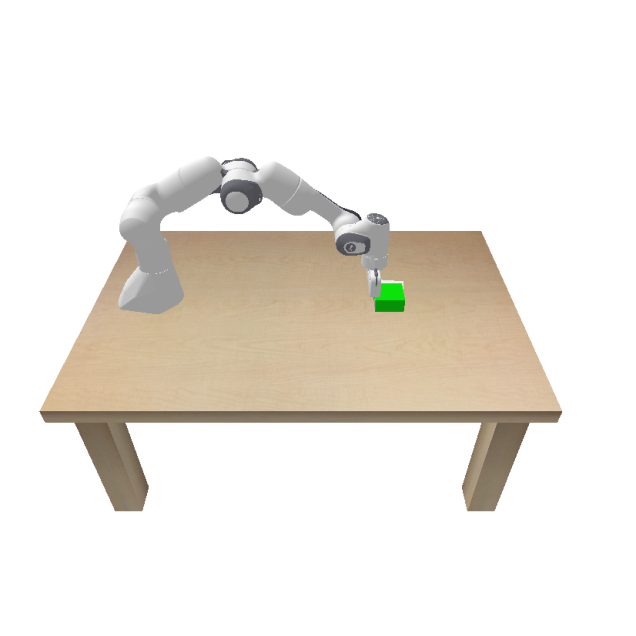

argv[0]=--opengl2


 55%|█████▌    | 11/20 [00:08<00:06,  1.29it/s]

GOAL REACHED: True


In [137]:
# Control on an obstacle free environment
%matplotlib inline
%reload_ext autoreload

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_residual_dynamics_model, free_pushing_cost_function, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)




### 4.2 - Pushing with Obstacles (15 points)
Now, we will repeat the task but adding an obstacle to the scene. The goal is to push the block to the goal while avoiding the obstacle.
You will have to first implement a basic collision detection algorithm. 

Then, you will have to use the collision detection inside the cost function to assign high cost to in-collision trajectories

#### 4.2.1 - Collision Detection Function (5 points)

The obstacle we are considering is a rectangle. At a given SE2 pose $[x, y, \theta]$ we can check collision by checking whether or not these two rectangles intersect. 

![Action Space](https://drive.google.com/uc?export=view&id=1yC2SxtbtmhInkYk-rzR2TAAYuD4JM-I0)

**TODO:**
* Implement `collision_detection` in `learning_state_dynamics.py`.
* The relevant parameters $(w, w_{obs} l_{obs}, x_{obs}, y_{obs})$ are already specified inside the function as `box_size`, `obstacle_dims`, and `obstacle_centre`. 


In [127]:
from learning_state_dynamics import collision_detection

# let's test the collision detection with two states
# The first should be in collision, the second should not

states = torch.tensor([
    [0.6, 0.2, 0.0],
    [0.3, 0.15, 0.7]
])

collision = collision_detection(states)

print(f'First state in collision? {collision[0]}')
print(f'Second state in collision? {collision[1]}')


First state in collision? 1.0
Second state in collision? 0.0


#### 4.2.2 - Cost Function for Obstacle Avoidance (10 points)

You should implement a new cost function to reach the goal while avoiding the obstacle. The cost should be
$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} \left((\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal}) + 100 \texttt{in\_collision}(\mathbf x_t)\right)$$

With $Q$ defined as in the obstacle-free case, and `in_collision` is the binary output of the collision detection function you implemented above. This should add an additional state cost of 100 whenever a state is in collision.

**TODO:**

* Implement `obstacle_avoidance_pushing_cost_function` in `learning_state_dynamics.py`.

If implemented successfully, you should see the robot pushing the block around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally get the block stuck on the obstacle, but should complete the task successfully more often than not.

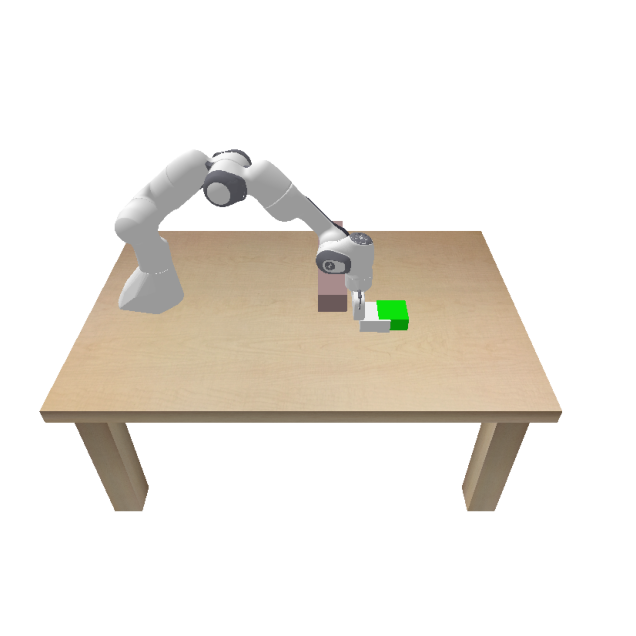

argv[0]=--opengl2


 20%|██        | 4/20 [00:05<00:21,  1.34s/it]

GOAL REACHED: True


In [139]:
# Control on an obstacle free environment
from learning_state_dynamics import *
%matplotlib inline
%reload_ext autoreload

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
# Evaluate state
plt.close(fig)